In [1]:
# === 기본 세팅 ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [7]:
RAW_DIR = Path("../data/raw")
DATA_PATH = RAW_DIR / "connect-4.csv"

In [9]:
# === data load ===
df = pd.read_csv(DATA_PATH)
print("data size:", df.shape)
df.head()

data size: (67557, 43)


,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,...,f4,f5,f6,g1,g2,g3,g4,g5,g6,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


결측치 개수:
 0

타겟 분포:
target
2    0.658303
1    0.246237
0    0.095460
Name: proportion, dtype: float64


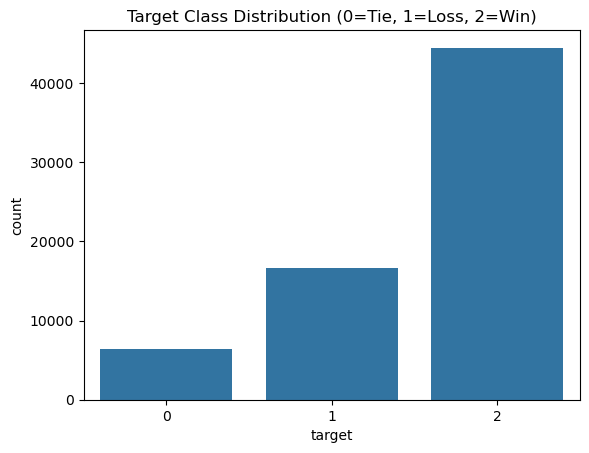

In [13]:
# === 결측치 / 기본 통계 ===
print("결측치 개수:\n", df.isnull().sum().sum())
print("\n타겟 분포:")
print(df['target'].value_counts(normalize=True))

# 시각화
sns.countplot(x='target', data=df)
plt.title("Target Class Distribution (0=Tie, 1=Loss, 2=Win)")
plt.show()


학습용 데이터 분리

80%는 학습용 20%는 테스트 용

In [17]:
# === Feature / Target 분리 ===
X = df.drop('target', axis=1)
y = df['target']

# Stratified 분할 (불균형 고려)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (54045, 42) Test size: (13512, 42)


first model : Logistic Regression (including OHE)

              precision    recall  f1-score   support

           0       0.22      0.55      0.31      1290
           1       0.62      0.66      0.64      3327
           2       0.91      0.68      0.78      8895

    accuracy                           0.66     13512
   macro avg       0.58      0.63      0.57     13512
weighted avg       0.77      0.66      0.70     13512



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


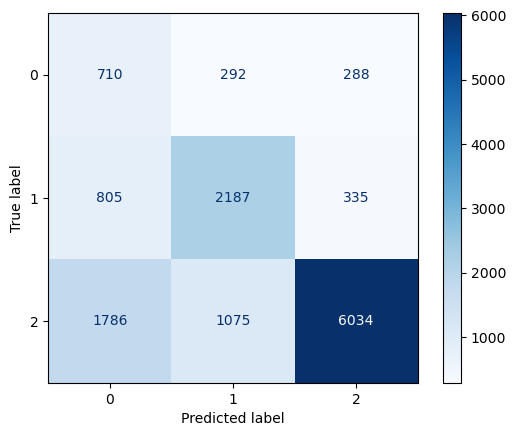

In [20]:
# === Logistic Regression Pipeline ===
ohe = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer(
    transformers=[('cat', ohe, X.columns)]
)

logreg = LogisticRegression(max_iter=200, class_weight="balanced", solver='lbfgs', multi_class='multinomial')

pipe_lr = Pipeline(steps=[('preprocess', preprocessor),
                         ('model', logreg)])

pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)

print(classification_report(y_test, y_pred_lr))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_lr)).plot(cmap="Blues")
plt.show()


second model : Random Forest (compare)

              precision    recall  f1-score   support

           0       0.51      0.13      0.21      1290
           1       0.81      0.69      0.74      3327
           2       0.83      0.96      0.89      8895

    accuracy                           0.82     13512
   macro avg       0.71      0.59      0.61     13512
weighted avg       0.79      0.82      0.79     13512



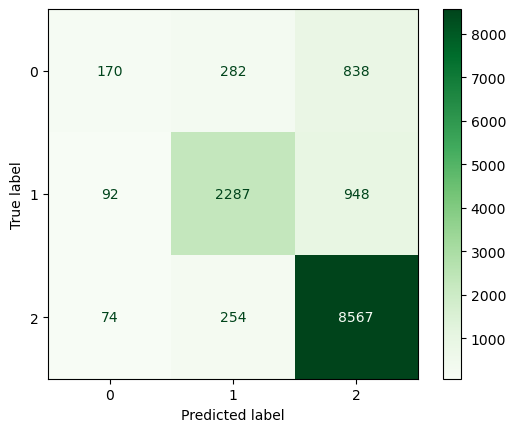

In [23]:
# === Random Forest ===
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight="balanced_subsample"
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(classification_report(y_test, y_pred_rf))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf)).plot(cmap="Greens")
plt.show()
